# **Exercise 1: MD simulations of LJ-Ag**

## *SVOLGIMENTO PUNTO 2*

---

## Consegna

### Parametri

In all simulations model Ag interatomic interactions using the LJ potential ($\varepsilon = 0.345$ eV and $\sigma = 2.644$ Å) with the cutoff radius at $R_C = 4.5$ Å. Assume $t_\text{th} = 3$ ps as thermalization time and use the simulation cell of 256-atoms (file `fcc100a256.txt` on the elearning page) unless stated differently. From point 3,

### Punto 1 ✅

Use a **sharp-cutoff** (no polynomial junction) approach and find the optimal timestep to perform a simulation from an initial temperature $T_\text{ini} = 50$ K. The optimal timestep is the maximum one such that $\frac{\delta E}{E} < 10^{−5}$. Consider the range 1, 25 fs and perform 5000 integration steps for each trial. Repeat the analysis for $T_\text{ini} = 500$ K and show that the criterion cannot be fulfilled however reducing the timestep.

#### Risultato

Risulta un $dt$ minimo di 20 fs per i 50K. La simulazione a 500K non realizza mai la condizione: la variabilità è dominata dalla discontinuità del potenziale: ogni volta che una coppia di atomi attraversa $R_C$, il sistema guadagna o perde istantaneamente una quantità finita di energia potenziale. Più è alta la temperatura, più frequenti sono gli eventi di _crossing_ della regione di cutoff, in una direzione e nell'altra.

### Punto 2 ⚒️

Implement a **7-degree polynomial** junction for $R_P < r < R_C$ with $R_P = 4.2$ Å. Use the coefficients $A, B, \dots, H$ for the 0th, 1st, ..., 7th degree term respectively, as provided in the file `poly7.py` on the elearning page. Adapt the definition of forces accordingly. Check that for $T_\text{ini} = 50$ K the simulation is consistent with the sharp-cutoff one and find the optimal timestep for $T_\text{ini} = 500$ K, $1000$ K and $2000$ K.

### Punto 3 🔜

For the following points, implement a steepest-descent procedure to start the simulation from a minimum energy configuration (use C= 0.005 Å/𝑒𝑉 and stop when the maximum force falls below 0.001 𝑒𝑉/Å).


Using the optimal timesteps found in point 2, perform 10 𝑝𝑠 long simulations for $T_\text{ini} = 500$ K, $1000$ K and $2000$ K. Plot $\langle T \rangle$ as a function of $T_\text{ini}$ , check if the condition $\langle T \rangle = \frac{T_\text{ini}}{2}$ is
fulfilled and explain the result. Visualize the atomic trajectories of the atoms at the center of the
cluster and at the cube vertices for both the lowest and highest temperature and comment on
their difference.

### Punto 4 🔜

Consider an infinite crystal slab (𝐿𝑥 = 𝐿𝑦 = 16.6416 Å) with free-surfaces in the 𝑧 direction. Add one adatom at the center of the upper surface, with 𝑧 coordinate set 2.4 Å above the maximum 𝑧 coordinate of the atoms in the cell. Perform a 300 𝑝𝑠 long simulation starting from the minimized configuration. Set 𝑇𝑖𝑛𝑖 such to achieve an equilibrium temperature 𝑇 = 850 ± 30 𝐾 and use an appropriate timestep. Trace the trajectory of the adatom over time.

### Punto 5 🔜

Repeat the analysis of point 4 using a (111)-oriented cell from the file fcc111a336+1.txt on the elearning page with 𝐿𝑥 = 𝐿𝑦 = 20.3817 Å and compare the results for the two orientations. Is the adatom diffusion likely to happen at room temperature on one or both surfaces on the same time interval?

---

## Svolgimento PUNTO 2

### 0) Importazioni e dati

In [1]:
import numpy as np
from CMS.MolecularDynamics import CrystalStructure as Crystal
from CMS.MolecularDynamics import CrystalDynamics as Dynamics

In [2]:
# Nome del file (numero di atomi da studiare: 256)
filename = '../../../data/pos-fcc100-random/fcc100a256.txt'

#### Dati globali

In [3]:
# massa atomica dell'atomo considerato (argento)
silver_mass = 108

# range 1-25 fs per il time step
time_steps_50 = np.arange(1e-15, 25e-15, 1e-15)
time_steps_others = np.arange(1e-15, 10e-15, 1e-15) # inutile a T alte usare time step grandi

# 5000 step per ogni simulazione
n_steps = 5000

# tempo di termalizzazione (ogni valore precedente va buttato)
t_th = 3e-12

# raggi di cutoff e giunzione polinomiale
R_C = 4.5
R_P = 4.2

### 1) Consistenza di T=50K e optimal timestep

#### 1.1) Dati

In [4]:
# temperature iniziali da studiare
T_ini_punto_2_1 = [50]

#### 1.2) Mostro che T=50K con giunzione polinomica è consistente

In [5]:
# Raccolgo le energie medie e le dev std
E_tot_means = {}
E_tot_stds = {}

E_tot_list = {}
E_k_list = {}
T_list = {}

for T in T_ini_punto_2_1: # in realtà una sola T iniziale: 50 K
    print(f"🚀 Avvio simulazione con temperatura iniziale T = {T} K")
    
    E_tot_means[T] = []
    E_tot_stds[T] = []
    
    E_tot_list[T] = []
    E_k_list[T] = []
    T_list[T] = []
        
    for dt in time_steps_50: # venticinque time step diversi
        # Ogni volta inizializzo da capo il cristallo
        cristallo = Crystal.from_file(filename)
        # setto il raggio di cutoff E la giunzione polinomiale
        cristallo.set_R_C(R_C) 
        cristallo.set_R_P(R_P)
        
        # PROVO A SETTARE ANCHE UN R_V PER LA VERLET CAGE
        R_V = R_C + 0.5
        #cristallo.set_R_V(R_V)
    
        print(f"• dt = {dt} s")
        simulazione = Dynamics(cristallo, atomic_mass=silver_mass, dt=dt, temp_ini=T)
        simulazione.set_seed(12316543)
        result = simulazione.run_dynamics(n_steps=n_steps, t_th=t_th, output=False, debug=False)
        
        # Accesso ai campi dell'oggetto result
        E_tot_means[T].append(result.mean_E_tot)
        E_tot_stds[T].append(result.std_E_tot)
        
        E_tot_list[T].append(result.energies['total'])
        E_k_list[T].append(result.energies['kinetic'])
        T_list[T].append(result.temperatures)

🚀 Avvio simulazione con temperatura iniziale T = 50 K
• dt = 1e-15 s
• dt = 2e-15 s
• dt = 3.0000000000000002e-15 s
• dt = 4e-15 s
• dt = 5.000000000000001e-15 s
• dt = 6.0000000000000005e-15 s
• dt = 7e-15 s
• dt = 8e-15 s
• dt = 9.000000000000001e-15 s
• dt = 1.0000000000000002e-14 s
• dt = 1.1e-14 s
• dt = 1.2000000000000001e-14 s
• dt = 1.3000000000000001e-14 s
• dt = 1.4e-14 s
• dt = 1.5000000000000002e-14 s
• dt = 1.6e-14 s
• dt = 1.7e-14 s
• dt = 1.8000000000000002e-14 s
• dt = 1.9e-14 s
• dt = 2.0000000000000003e-14 s
• dt = 2.1000000000000002e-14 s
• dt = 2.2e-14 s
• dt = 2.3000000000000003e-14 s
• dt = 2.4000000000000002e-14 s


#### 1.3) Analisi e plot

Grafico $\delta E/\langle E\rangle$ vs dt

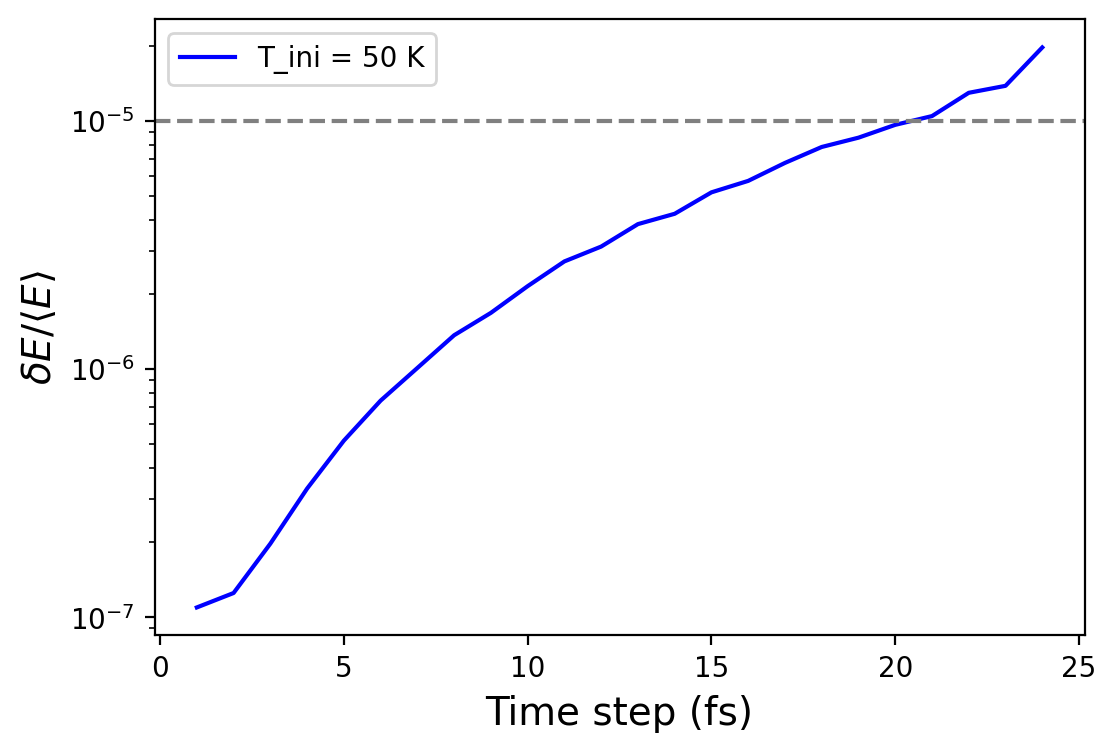

In [6]:
import matplotlib.pyplot as plt

rapporti = {}
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, T in enumerate(T_ini_punto_2_1):
    rapporto = np.array(E_tot_stds[T])/np.abs(np.array(E_tot_means[T]))
    rapporti[T] = rapporto
    plt.figure(figsize=(6,4), dpi=200)
    plt.plot(time_steps_50*1e15, rapporto, color=colors[i], label=f'T_ini = {T} K')
    plt.axhline(y=1e-5, color='gray', linestyle='--')
    plt.xlabel('Time step (fs)', fontsize=14)
    plt.ylabel(r'$\delta E/\langle E \rangle$', fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.show()

In [7]:
# prendo l'ultimo rapporto minore di 1e-5 per ogni temperatura
for T in T_ini_punto_2_1:
    indice_ultimo = 0
    trovato = False
    
    rapporto = rapporti[T]
    for i, val in enumerate(rapporto):
        if val < 1e-5:
            indice_ultimo = i
            trovato = True
            
    if trovato:
        print(f"\nPer T_ini = {T} K, l'ultimo rapporto < 1e-5 è a dt = {time_steps_50[indice_ultimo]*1e15} fs con rapporto = {rapporto[indice_ultimo]}")
    else:   
        print(f"\nPer T_ini = {T} K, non esiste un rapporto < 1e-5 nei time step considerati.")


Per T_ini = 50 K, l'ultimo rapporto < 1e-5 è a dt = 20.000000000000004 fs con rapporto = 9.636093039541505e-06


#### **OSSERVAZIONE**

Consistente con quanto visto al punto 1 con lo sharp cutoff! Il codice funziona bene, la giunzione polinomiale praticamente non interviene, perché a 50K gli atomi vibrano molto poco e hanno basse probabilità di attraversare (entrare o uscire da) la regione di cutoff.

### 2) Timestep ottimale per T = 500, 1000, 2000

#### 2.1) Dati

In [8]:
# temperature iniziali da studiare
T_ini_punto_2_2 = [500, 1000, 1700, 2000]

#### 2.2) Simulazioni per T = 500, 1000, 1700, 2000 K

In [9]:
# Raccolgo le energie medie e le dev std nei dict di prima

for T in T_ini_punto_2_2: 
    print(f"\n=== Simulazioni per temperatura iniziale T = {T} K ===")
    
    E_tot_means[T] = []
    E_tot_stds[T] = []
    
    E_tot_list[T] = []
    E_k_list[T] = []
    T_list[T] = []
        
    for dt in time_steps_others: # venticinque time step diversi
        # Ogni volta inizializzo da capo il cristallo
        cristallo = Crystal.from_file(filename)
        # setto il raggio di cutoff E la giunzione polinomiale
        cristallo.set_R_C(R_C)
        cristallo.set_R_P(R_P)
        
        # PROVO A SETTARE ANCHE UN R_V PER LA VERLET CAGE
        R_V = R_C + 0.5
        cristallo.set_R_V(R_V)
    
        print(f"\n--- Simulazione con dt = {dt} s, n_steps = {n_steps} ---")
        simulazione = Dynamics(cristallo, atomic_mass=silver_mass, dt=dt, temp_ini=T)
        simulazione.set_seed(1543) # 12316543
        result = simulazione.run_dynamics(n_steps=n_steps, t_th=t_th, output=False, debug=False)
        
        # Accesso ai campi dell'oggetto result
        E_tot_means[T].append(result.mean_E_tot)
        E_tot_stds[T].append(result.std_E_tot)
        
        E_tot_list[T].append(result.energies['total'])
        E_k_list[T].append(result.energies['kinetic'])
        T_list[T].append(result.temperatures)


=== Simulazioni per temperatura iniziale T = 500 K ===

--- Simulazione con dt = 1e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 2e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 3.0000000000000002e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 4e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 5.000000000000001e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 6.0000000000000005e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 7e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 8e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 9.000000000000001e-15 s, n_steps = 5000 ---

=== Simulazioni per temperatura iniziale T = 1000 K ===

--- Simulazione con dt = 1e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 2e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 3.0000000000000002e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 4e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 5.000000000000001e-15 s, n_steps = 5000 ---

--- Simulazione con dt = 6.0000

#### 2.3) Analisi e plot

Grafico $\delta E/\langle E\rangle$ vs dt

In [10]:
rapporti

{50: array([1.09323231e-07, 1.24997785e-07, 1.97589740e-07, 3.29443650e-07,
        5.14011427e-07, 7.45343824e-07, 1.00914074e-06, 1.36731348e-06,
        1.68307376e-06, 2.15622753e-06, 2.71290419e-06, 3.11367346e-06,
        3.83483790e-06, 4.22117723e-06, 5.15010137e-06, 5.72814214e-06,
        6.76749765e-06, 7.84622455e-06, 8.55422082e-06, 9.63609304e-06,
        1.04522181e-05, 1.29732146e-05, 1.38413877e-05, 1.97631778e-05])}

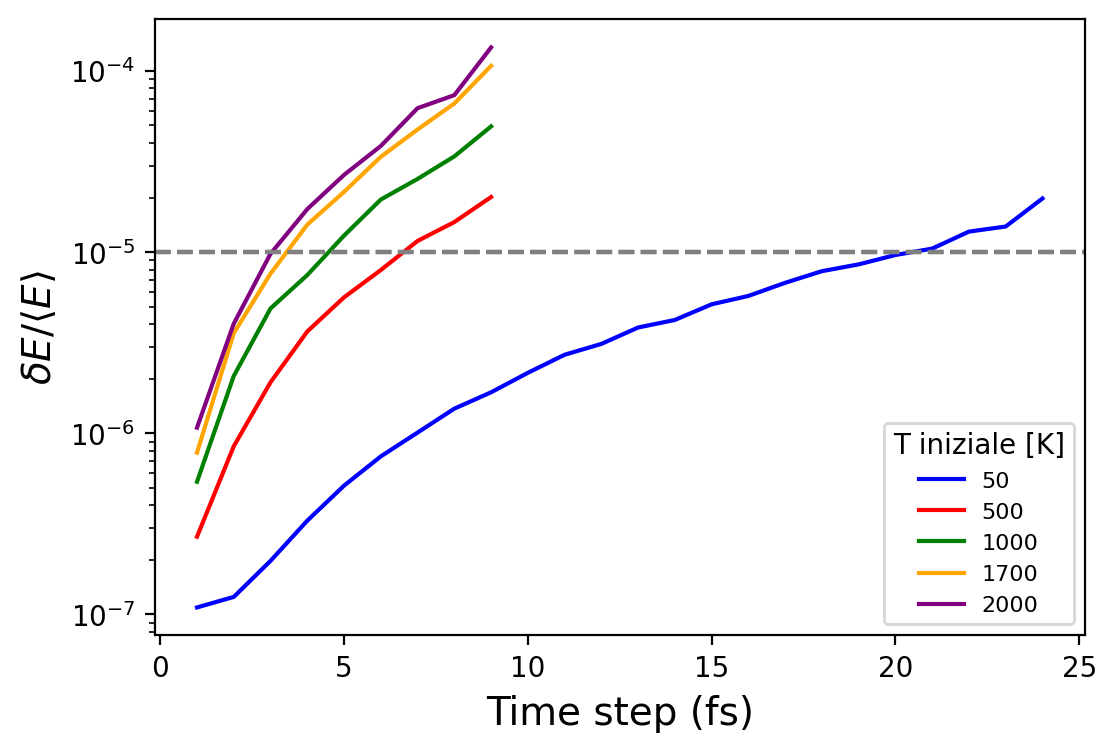

In [11]:
plt.figure(figsize=(6,4), dpi=200)
plt.plot(time_steps_50*1e15, rapporti[50], colors[0], label='50')
for i, T in enumerate(T_ini_punto_2_2):
    rapporto = np.array(E_tot_stds[T])/np.abs(np.array(E_tot_means[T]))
    rapporti[T] = rapporto
    plt.plot(time_steps_others*1e15, rapporto, color=colors[i+1], label=f'{T}')
    # linea orizzontale a y=1e-5
    plt.axhline(y=1e-5, color='gray', linestyle='--')
plt.xlabel('Time step (fs)', fontsize=14)
plt.ylabel(r'$\delta E/\langle E \rangle$', fontsize=14)
plt.yscale('log')
plt.legend(title='T iniziale [K]', fontsize=8)
plt.show()

In [12]:
# prendo l'ultimo rapporto minore di 1e-5 per ogni temperatura
for T in T_ini_punto_2_2:
    indice_ultimo = -1
    rapporto = rapporti[T]
    for i, val in enumerate(rapporto):
        if val < 1e-5:
            indice_ultimo = i
            
    if i != -1:
        print(f"\nPer T_ini = {T} K, l'ultimo rapporto < 1e-5 è a dt = {time_steps_others[indice_ultimo]*1e15} fs con rapporto = {rapporto[indice_ultimo]}")
    else:   
        print(f"\nPer T_ini = {T} K, non esiste un rapporto < 1e-5 nei time step considerati.")


Per T_ini = 500 K, l'ultimo rapporto < 1e-5 è a dt = 6.000000000000001 fs con rapporto = 7.96031604868689e-06

Per T_ini = 1000 K, l'ultimo rapporto < 1e-5 è a dt = 4.0 fs con rapporto = 7.4694701261179354e-06

Per T_ini = 1700 K, l'ultimo rapporto < 1e-5 è a dt = 3.0000000000000004 fs con rapporto = 7.604470482726163e-06

Per T_ini = 2000 K, l'ultimo rapporto < 1e-5 è a dt = 3.0000000000000004 fs con rapporto = 9.789420404173485e-06


#### **OSSERVAZIONE**

Ora che il potenziale è liscio e senza discontinuità, l'errore nella conservazione dell'energia torna a dipendere solo dall'algoritmo Velocity Verlet.